# BATADAL - ARMA Task

## 2. Other signals

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/%28ASCE%29WR.1943-5452.0000969)).

This notebook is a sub-task for the *ARMA (autoregressive moving average model)* task. The purpose of this sub-task is to learn an ARMA model for four more individual sensors (pick them in a sensible way!). The signals selected for this task are:

- Water level of tank T1, *L_T1* (presented in the main notebook)
- Water level of tank T2, *L_T2*
- Water level of tank T3, *L_T3*
- Pressure at junction J302, *P_J302*
- Flowrate at pump PU2, *F_PU2*

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, ARMA
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import scale

### 2.0 Load the functions and data
Below we create functions for:
- making autocorrelation plot and partial autocorrelation plot,
- performing grid search for Akike Information Crieteria (AIC) for ARMA models,
- build and fit the ARMA model and make predictions

In [2]:
# plot autocorrelation plot and partial autocorrelation plot
def acf_pacf_plots(df, lag = 30):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (6, 4))
    
    fig = plot_acf(df, lags = lag, ax = ax1)
    fig = plot_pacf(df, lags = lag, ax = ax2)
    
    ax2.set_xlabel('Lag (hour)')

In [9]:
# perform aic calculations given orders (p, q) and plot the aic grid
def aic_heatmap(df, ps = range(1, 3), qs = range(1, 3), title = 'AIC Grid'):
    aic = [[p, q, ARMA(df, order=(p, q)).fit().aic]
           for p in ps for q in qs if ((p!=0)|(q!=0))]
    aic = pd.DataFrame(aic, columns = ['p', 'q', 'aic'])
    
    # plot heatmap showing aic values vs (p, q) parameters
    sns.heatmap(aic.pivot('p', 'q', 'aic'), 
                annot = True, fmt='0.1f', linewidths=1)
    plt.title(title)

In [12]:
def predict(coefficients, history):
    yhat = sum([coefficients[i-1] * history[-i] for i in range(1, len(coefficients)+1)])
    return yhat

# train model to predict the next value per time tick
def arma_train_predict(train, test, p, q, showlog = False):
    model = ARMA(train, order = (p, q)).fit() # fit model with training data
    ar_coef = model.arparams # get coefficients for AR part
    ma_coef = model.maparams # get coefficients for MA part
    max_residual = np.abs(model.resid).max() # max residual for train data
    # set history and residuals with training data
    history = [x for x in train]
    residual = [x for x in model.resid]
    predictions = [] # start prediction
    
    # predict the next time tick
    for t in range(len(test)):
        vPred = predict(ar_coef, history) + predict(ma_coef, residual)
        vReal = test[t]
        # book keeping
        predictions += [vPred]
        history += [vReal]
        residual += [vReal - vPred]
        if showlog:
            print('i = %i\treal:%0.2f\tpredict: %0.2f\tresidual: %0.2f' % (t, vReal, vPred, vReal-vPred))
    
    # calculate few output statistics
    error = rmse(test, np.array(predictions)) # root mean square error
    
    return predictions, error, max_residual

In [5]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')
dftrain2 = pd.read_csv('./data/BATADAL_dataset04.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

# Remove the spaces in column names
dftrain2.columns = dftrain2.columns.str.strip()

# Set timestamp as index
dftrain1.set_index('DATETIME', inplace = True)
dftrain2.set_index('DATETIME', inplace = True)

### 2.1 Selected signals

### a. Water level of tank T2, *L_T2*

In [6]:
signal = 'L_T2'
train = scale(dftrain1[signal])
test  = scale(dftrain2[signal])

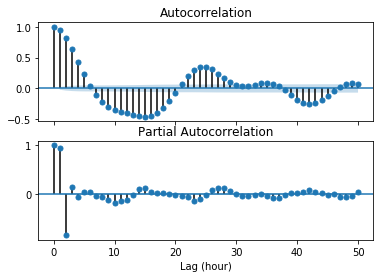

In [7]:
# plot acf and pacf plots
acf_pacf_plots(train, lag = 50)

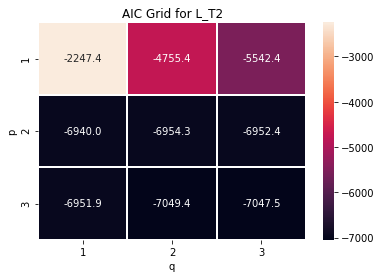

In [10]:
aic_heatmap(train, ps = range(1, 4), qs = range(1, 4), 
            title = 'AIC Grid for {}'.format(signal))

In [13]:
# perform arma modeling and predicting
predictions, error, max_residual = arma_train_predict(train, test, p=2, q=1) #if necessary set showlog = True

print('ARMA resulting root mean square error: %0.3f' % error)

ARMA resulting root mean square error: 0.163


Text(0, 0.5, 'Water level [meter]')

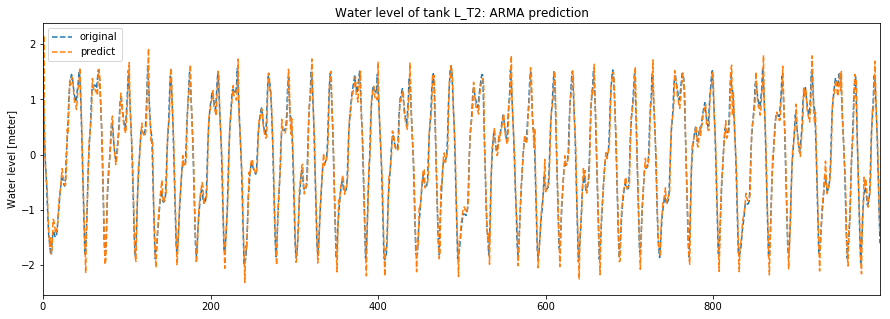

In [16]:
# plot the original predicted results
comparison = pd.DataFrame({'original' : test,
                           'predict' : predictions})
comparison[:1000].plot(style = '--', figsize=(15, 5))
plt.title('Water level of tank {}: ARMA prediction'.format(signal))
plt.ylabel('Water level [meter]')

### b. Water level of tank T3, *L_T3*

In [17]:
signal = 'L_T3'
train = scale(dftrain1[signal])
test  = scale(dftrain2[signal])

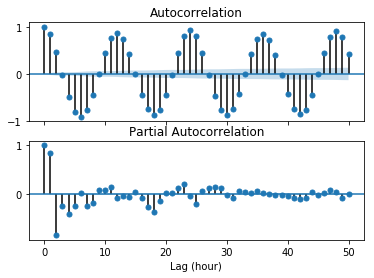

In [18]:
# plot acf and pacf plots
acf_pacf_plots(train, lag = 50)

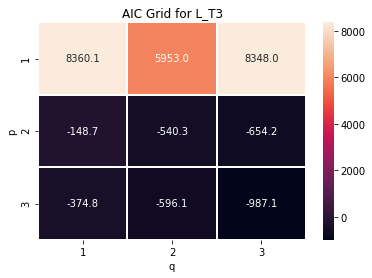

In [19]:
aic_heatmap(train, ps = range(1, 4), qs = range(1, 4), 
            title = 'AIC Grid for {}'.format(signal))

In [20]:
# perform arma modeling and predicting
predictions, error, max_residual = arma_train_predict(train, test, p=2, q=1) #if necessary set showlog = True

print('ARMA resulting root mean square error: %0.3f' % error)

ARMA resulting root mean square error: 0.242


Text(0, 0.5, 'Water level [meter]')

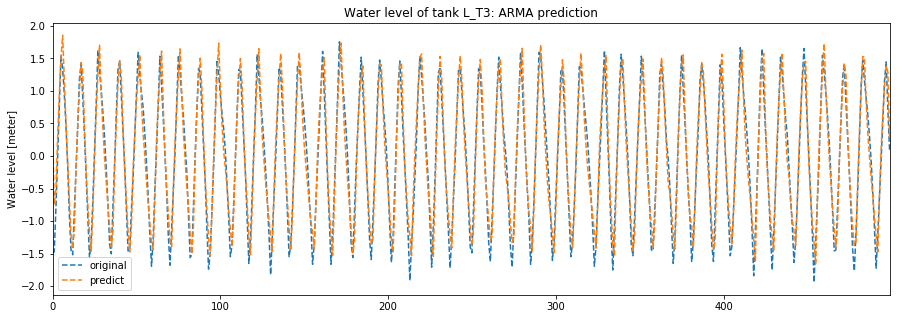

In [24]:
# plot the original predicted results
comparison = pd.DataFrame({'original' : test,
                           'predict' : predictions})
comparison[:500].plot(style = '--', figsize=(15, 5))
plt.title('Water level of tank {}: ARMA prediction'.format(signal))
plt.ylabel('Water level [meter]')

### c. Pressure at junction J302, *P_J302*

In [25]:
signal = 'P_J302'
train = scale(dftrain1[signal])
test  = scale(dftrain2[signal])

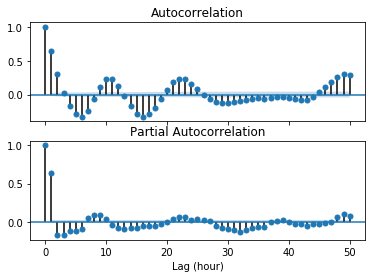

In [26]:
# plot acf and pacf plots
acf_pacf_plots(train, lag = 50)

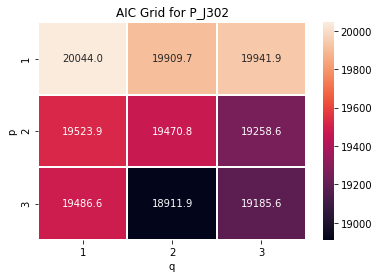

In [27]:
aic_heatmap(train, ps = range(1, 4), qs = range(1, 4), 
            title = 'AIC Grid for {}'.format(signal))

In [28]:
# perform arma modeling and predicting
predictions, error, max_residual = arma_train_predict(train, test, p=3, q=2) #if necessary set showlog = True

print('ARMA resulting root mean square error: %0.3f' % error)

ARMA resulting root mean square error: 0.731


Text(0, 0.5, 'Water level [meter]')

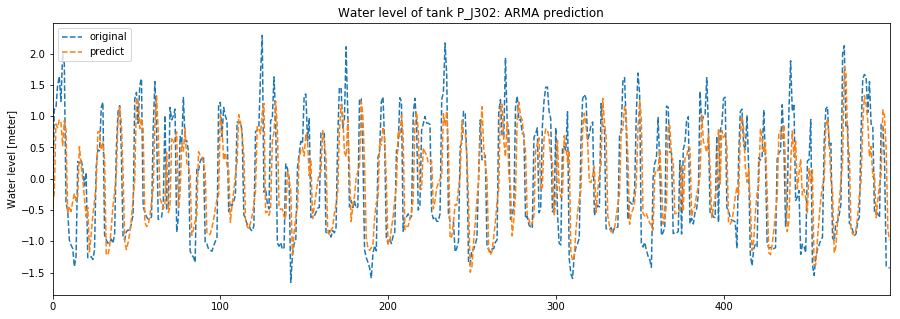

In [30]:
# plot the original predicted results
comparison = pd.DataFrame({'original' : test,
                           'predict' : predictions})
comparison[:500].plot(style = '--', figsize=(15, 5))
plt.title('Water level of tank {}: ARMA prediction'.format(signal))
plt.ylabel('Water level [meter]')

### d. Flowrate at pump PU2, *F_PU2*

In [31]:
signal = 'F_PU2'
train = scale(dftrain1[signal])
test  = scale(dftrain2[signal])

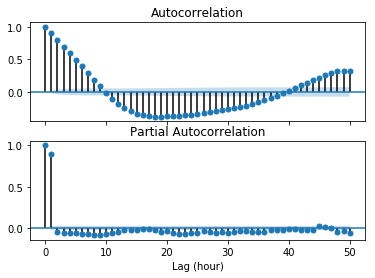

In [32]:
# plot acf and pacf plots
acf_pacf_plots(train, lag = 50)

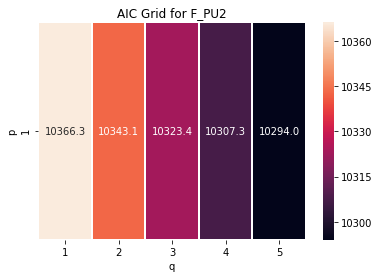

In [33]:
aic_heatmap(train, ps = range(1, 1+1), qs = range(1, 5+1), 
            title = 'AIC Grid for {}'.format(signal))

In [34]:
# perform arma modeling and predicting
predictions, error, max_residual = arma_train_predict(train, test, p=1, q=5) #if necessary set showlog = True

print('ARMA resulting root mean square error: %0.3f' % error)

ARMA resulting root mean square error: 0.439


Text(0, 0.5, 'Water level [meter]')

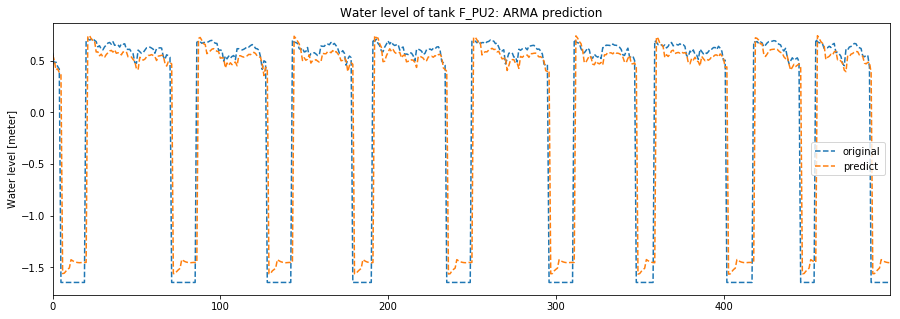

In [36]:
# plot the original predicted results
comparison = pd.DataFrame({'original' : test,
                           'predict' : predictions})
comparison[:500].plot(style = '--', figsize=(15, 5))
plt.title('Water level of tank {}: ARMA prediction'.format(signal))
plt.ylabel('Water level [meter]')

### 2.2 Conclusions

From above results we can see that ARMA model performs better in dealing with "continuous" data - in this case, the signals of water level of tanks.